<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Natural Language Processing Lab

---

In this lab we will further explore sklearn and NLTK's capabilities for processing text. We will use the 20 Newsgroup dataset, which is provided by sklearn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Getting the SKLearn Dataset
from sklearn.datasets import fetch_20newsgroups

### 1. Use the `fetch_20newsgroups` function to download a training and testing set.

Look up the [function documentation](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) for how to grab the data.

You should pull these categories:
- `alt.atheism`
- `talk.religion.misc`
- `comp.graphics`
- `sci.space`

Also remove the headers, footers, and quotes using the `remove` keyword argument of the function.

In [3]:
# Extracting Information from the Data's Dictionary format 
# Categories of emails we want
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Setting training data
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))
# Setting testing data
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

### 2. Data inspection

We have downloaded a few newsgroup categories and removed headers, footers and quotes.

Because this is an sklearn dataset, it comes with pre-split train and test sets (note we were able to call 'train' and 'test' in subset).

Let's inspect them.

1. What data type is `data_train`?
- What does `data_train` contain? 
- How many data points does `data_train` contain?
- How many data points of each category does `data_train` contain?
- Inspect the first data point, what does it look like?

In [4]:
type(data_train)

sklearn.utils.Bunch

In [5]:
list(data_train.keys())

['data', 'filenames', 'target_names', 'target', 'DESCR', 'description']

In [6]:
# Making sure our  Data and Target columns are equal length
len(data_train['data'])

2034

In [7]:
len(data_train['target'])

2034

In [8]:
# Let's check what our data actually looks like.
print(data_train['data'][0])

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


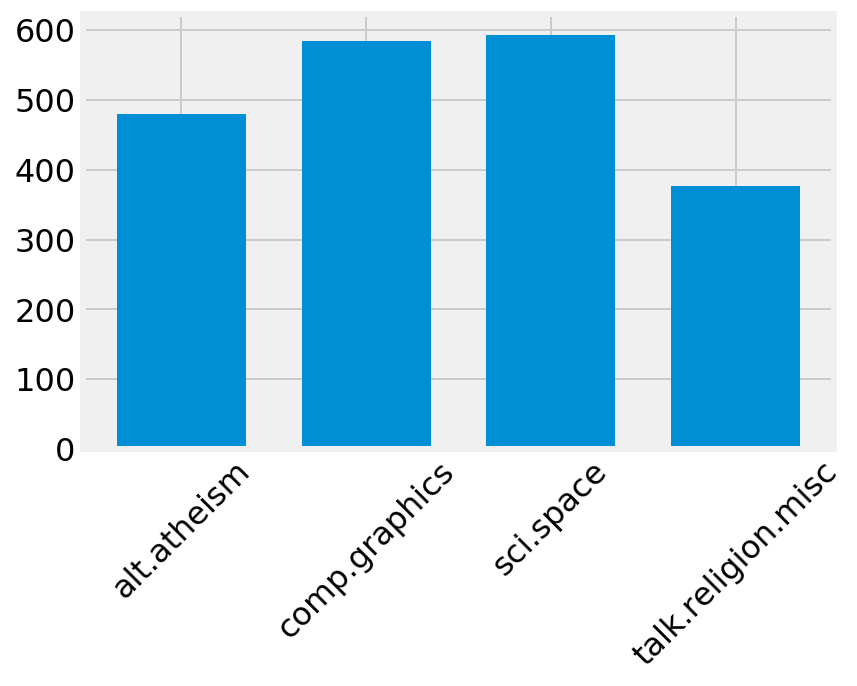

In [9]:
plt.hist(data_train.target,bins=np.linspace(0,4,5),align='left',rwidth=0.7)
plt.yticks(fontsize=16)
plt.xticks(list(range(4)),data_train.target_names,fontsize=16,rotation=45)
plt.show()

### 3. Bag of Words model

Let's train a model using a simple count vectorizer.

1. Initialize a standard CountVectorizer and fit the training data.
- How big is the feature dictionary?
- Repeat eliminating English stop words.
- Is the dictionary smaller?
- Transform the training data using the trained vectorizer.
- What are the 20 words that are most common in the whole corpus?
- What are the 20 most common words in each of the 4 classes?
- Evaluate the performance of a Logistic Regression on the features extracted by the CountVectorizer.
    - You will have to transform the test_set, too. Be careful to use the trained vectorizer without re-fitting it.
    - Create a confusion matrix.

**BONUS:**
- Try a couple of modifications:
    - restrict max_features
    - change max_df and min_df
    - for each of the above print a confusion matrix and investigate what gets mixed

#### Transformation and word frequencies

In [10]:
# What does the target variable look like
print(data_train['target'])

[1 3 2 ... 1 0 1]


In [11]:
# NLP Using a count vectorizer.  
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer()

# Fitting the vectorizer on our training data
cvec.fit(data_train['data'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
# Lets check the length of our data that is in a vectorized state
len(cvec.get_feature_names())

26879

In [14]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(data_train['data'])

# Transform training data
cvec_mat = cvec.transform(data_train['data'])

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

['brow', 'brown', 'browning', 'browns', 'browse', 'browsing', 'bruce', 'bruces', 'bruise', 'bruised', 'bruises', 'brunner', 'brush', 'brushmapping', 'brushmaps', 'brussel', 'brutal', 'brutally', 'brute', 'bryan']

26576


 We still have the same number of rows but the vectorization has converted every word, 
 or what is believed to be a word, from our test data into a feature.  This is like dummy coded
 variables for words except that we have counts rather than just occurances.

In [15]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [16]:
csum = word_counter(cvec_mat)
csum

array([ 59, 130,   2, ...,   1,   2,   2], dtype=int64)

In [17]:
cvec_mat.sum(axis=0)

matrix([[ 59, 130,   2, ...,   1,   2,   2]], dtype=int64)

In [18]:
# sort words by frequency
from operator import itemgetter

def word_frequency_sorter(words,counts):
    sort_result = sorted(zip(words,list(counts)),key=itemgetter(1),reverse=True)
    return sort_result

In [19]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words,csum),columns=['word','frequency'])
df_word_frequency.set_index('word',inplace=True)
df_word_frequency.head(20)

,frequency
word,
space,1061
people,793
god,745
don,730
like,682
just,675
does,600
know,592
think,584


We could do the same in pandas, but that requires transforming to dense matrix format (or to array).

In [20]:
df_cvec = pd.DataFrame(cvec_mat.toarray(),columns=cvec.get_feature_names())
df_cvec.sum(axis=0).sort_values(ascending=False)[:10]

space     1061
people     793
god        745
don        730
like       682
just       675
does       600
know       592
think      584
time       546
dtype: int64

#### Plotting the word frequency distribution, we observe [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law):

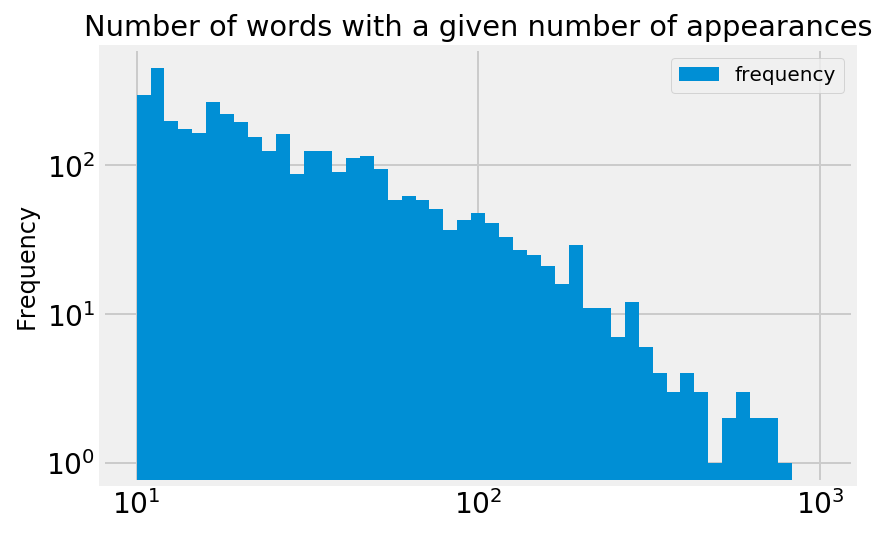

In [21]:
df_word_frequency.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()

#### Look at the most important words within each category:

In [22]:
df_word_frequency = {}
for i in range(4):
    csum_i = word_counter(cvec_mat[data_train.target==i,:])

    df_word_frequency[i] = pd.DataFrame(word_frequency_sorter(words,csum_i),columns=['word','frequency'])
    df_word_frequency[i].set_index('word',inplace=True)
    print(data_train.target_names[i])
    print(df_word_frequency[i].head(20))
    print()

alt.atheism
          frequency
word               
god             405
people          330
don             262
think           215
just            209
does            207
atheism         199
say             174
believe         163
atheists        162
like            162
religion        156
jesus           155
know            154
argument        148
time            135
said            131
true            131
bible           121
way             120

comp.graphics
           frequency
word                
image            484
graphics         410
edu              297
jpeg             267
file             265
use              225
data             219
files            217
images           212
software         212
program          199
ftp              189
available        185
format           178
color            174
like             167
know             165
pub              161
gif              160
does             157

sci.space
           frequency
word                
space            9

In [23]:
from wordcloud import WordCloud

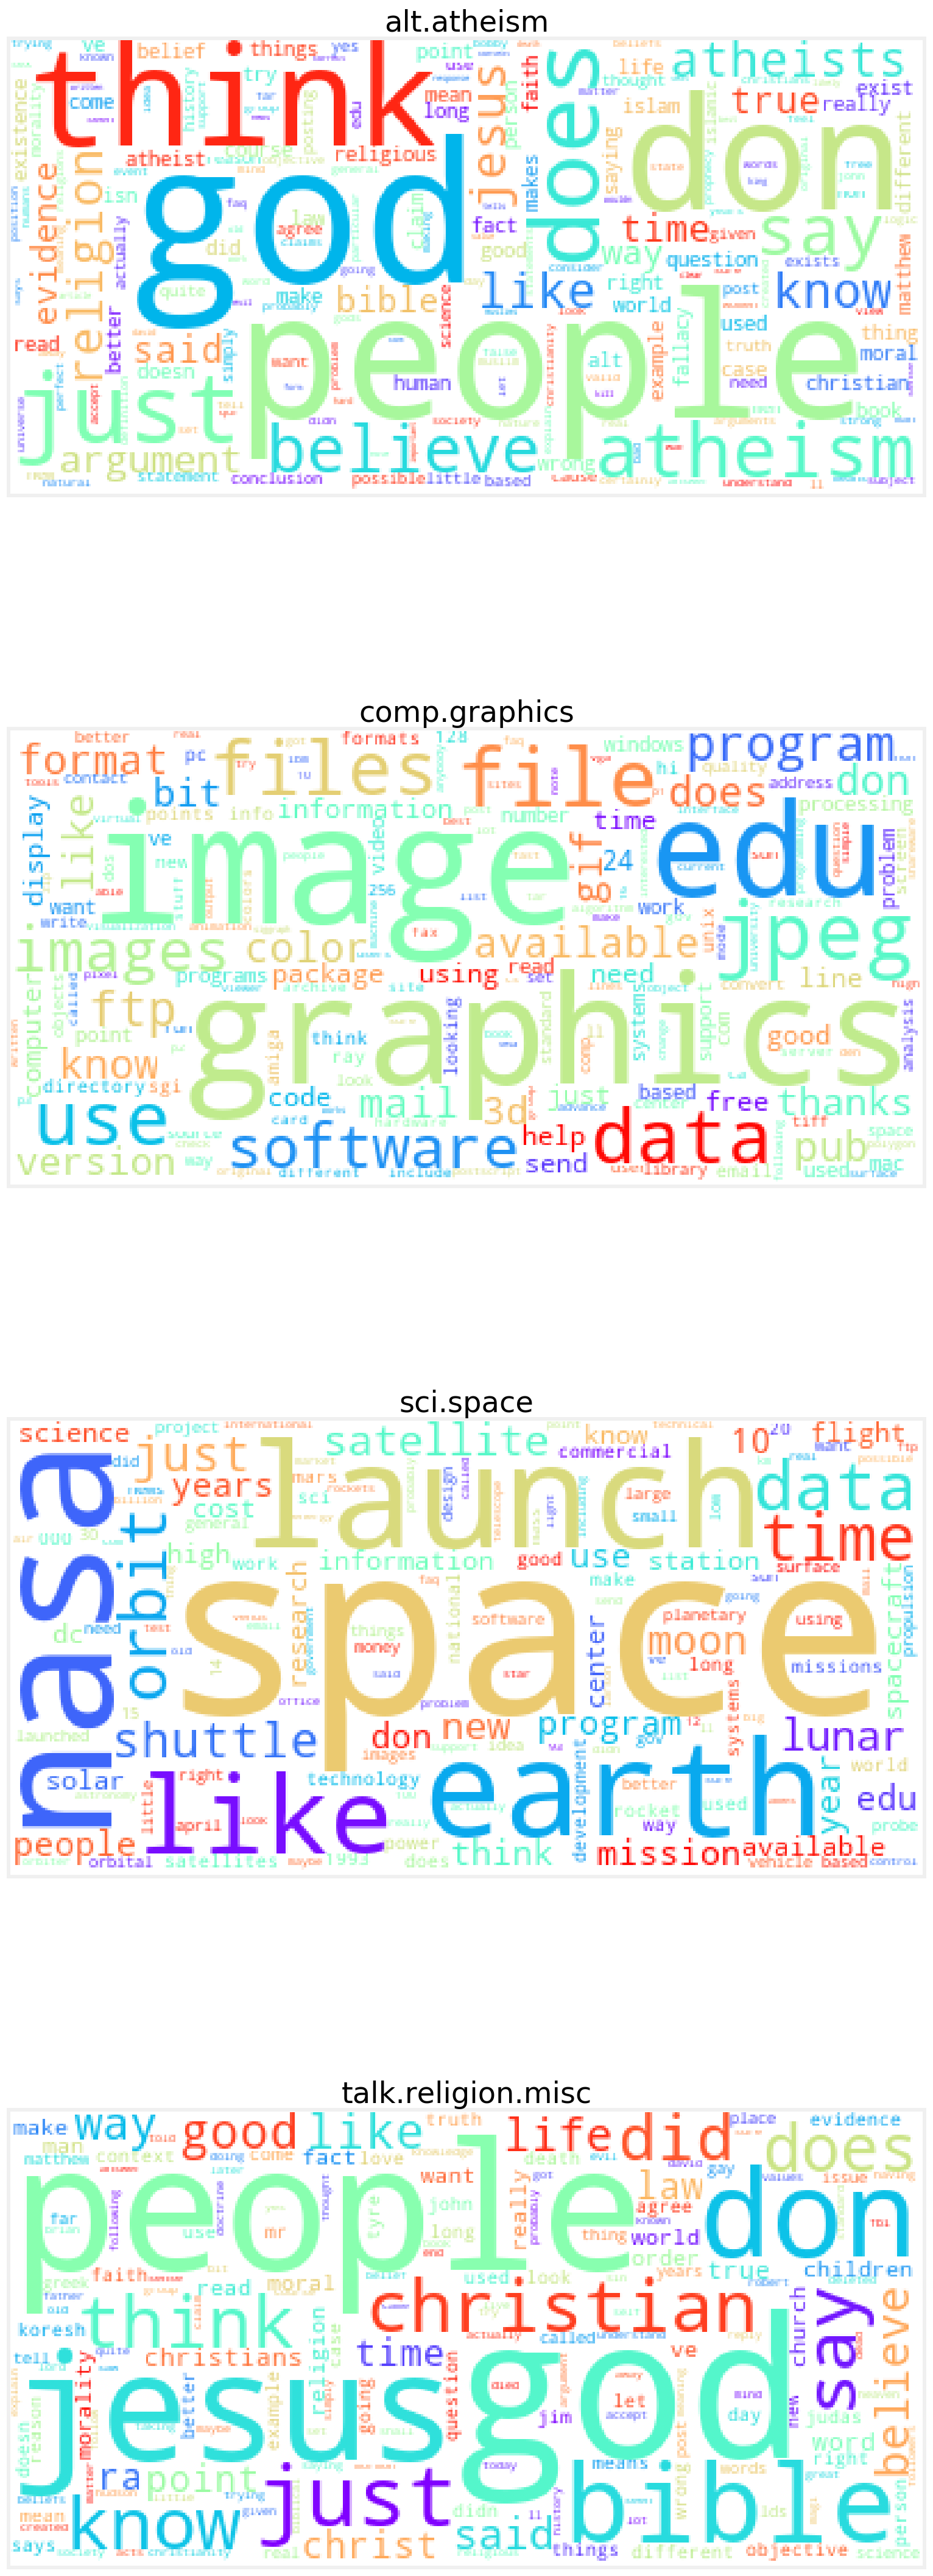

In [24]:

wc_gen = {}
wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2)

fig, ax = plt.subplots(nrows=4,figsize=(12,40))

for i in range(len(df_word_frequency)):
    wc_gen[i] = wc.generate_from_frequencies(dict(df_word_frequency[i].reset_index().values))
    ax[i].imshow(wc_gen[i])
    ax[i].set_title(data_train.target_names[i],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

#### Fit a logistic regression model

In [25]:
X_train = cvec_mat
y_train = data_train.target
X_test = cvec.transform(data_test.data)
y_test = data_test.target

In [26]:
#Import and fit our logistic regression and test it, too
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7450110864745011

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [28]:
docm(y_test,lr.predict(X_test),labels=data_train.target_names)

,p_alt.atheism,p_comp.graphics,p_sci.space,p_talk.religion.misc
alt.atheism,187,16,46,70
comp.graphics,13,345,28,3
sci.space,22,23,333,16
talk.religion.misc,67,14,27,143


In [29]:
print(classification_report(y_test,lr.predict(X_test),target_names=data_train.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.65      0.59      0.62       319
     comp.graphics       0.87      0.89      0.88       389
         sci.space       0.77      0.85      0.80       394
talk.religion.misc       0.62      0.57      0.59       251

       avg / total       0.74      0.75      0.74      1353



### 4. Hashing and TF-IDF

Let's see if Hashing or TF-IDF improves the accuracy.

1. Initialize a HashingVectorizer and repeat the test with no restriction on the number of features.
- Does the score improve with respect to the count vectorizer? 
- Print out the number of features for this model.
- Initialize a TF-IDF Vectorizer and repeat the analysis above.

**BONUS:**
- Change the parameters of either (or both!) models to improve your score.

In [30]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

#### Hashing Vectorizer

In [37]:
# A pipeline is a way for us to construct a function to execute
# the same tasks repeatedly
# In our variable model we fit a vectorizer and a model
# our Model variable is stored with the fit vectorizer and model
# so we we call model.xxxx to use that stored information
model = make_pipeline(HashingVectorizer(stop_words='english',
                                        n_features=2**15),
                      LogisticRegression(),
                      )
a = model.fit(data_train.data, y_train)
y_pred = model.predict(data_test.data)
print(accuracy_score(y_test, y_pred))
print("Number of features:", model.named_steps['hashingvectorizer'].n_features)

0.7398373983739838
Number of features: 32768


#### Tfidf Vectorizer

In [52]:
model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      #sublinear_tf=True,
                                      max_df=0.3,
                                      max_features=4000
                                     ),
                      LogisticRegression(),
                      )
model.fit(data_train.data, y_train)
y_pred = model.predict(data_test.data)
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.7509238728750924
Number of features: 4000


## 5. Classifier comparison

Of all the vectorizers tested above, choose one that has a reasonable performance with a manageable number of features and compare the performance of these models:

- KNN
- Logistic Regression
- Decision Trees
- Support Vector Machine
- Random Forest
- Extra Trees

In order to speed up the calculation it's better to vectorize the data only once and then compare the models.

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [54]:
models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(),
          RandomForestClassifier(),
          ExtraTreesClassifier()]

tvec = TfidfVectorizer(stop_words='english',
                       #sublinear_tf=True,
                       max_df=0.5,
                       max_features=1000)

tvec.fit(data_train['data'])
X_train = tvec.transform(data_train['data'])
X_test = tvec.transform(data_test['data'])

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    print() 
    cm = docm(y_test, y_pred, data_train.target_names)
    print(cm)
    res.append([model, score])
    print() 
    print('-'*60)
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

0.2934220251293422

                    p_alt.atheism  p_comp.graphics  p_sci.space  \
alt.atheism                   137               76           51   
comp.graphics                 147              128           42   
sci.space                     133              111           74   
talk.religion.misc             84               72           37   

                    p_talk.religion.misc  
alt.atheism                           55  
comp.graphics                         72  
sci.space                             76  
talk.religion.misc                    58  

------------------------------------------------------------

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver=

## Bonus: Other classifiers

Adapt the code from [this example](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py) to compare across all the classifiers suggested and to display the final plot

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.058s
test time:  0.002s
accuracy:   0.712
dimensionality: 1000
density: 1.000000
top 10 keywords per class:
alt.atheism: stay satan tells atheist religion punishment islamic atheists at...
comp.graphics: image card using looking points file hi 3d computer graphics
sci.space: expected engineering star flight 23 spacecraft nasa sci orbit space
talk.religion.misc: shall sin creation christ context children christian orde...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.62      0.55      0.58       319
     comp.graphics       0.84      0.85      0.84       389
         sci.space       0.72      0.83      0.77       394
talk.religion.mis

train time: 0.129s
test time:  0.001s
accuracy:   0.707
dimensionality: 1000
density: 0.392750
top 10 keywords per class:
alt.atheism: worse stay punishment satan atheist atheists islamic tells athei...
comp.graphics: video sgi computer hi file card points 3d image graphics
sci.space: dc mars nasa rocket flight 23 shuttle spacecraft orbit space
talk.religion.misc: holy creation children christian christians fbi order aut...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.59      0.54      0.56       319
     comp.graphics       0.87      0.84      0.86       389
         sci.space       0.72      0.82      0.77       394
talk.religion.misc       0.57      0.54      0.55       251

       avg / total       0.70      0.71      0.70      1353

confusion matrix:
[[171  16  57  75]
 [ 14 327  42   6]
 [ 30  21 323  20]
 [ 77  11  28 135]]

________________________________________________________________________________
Training

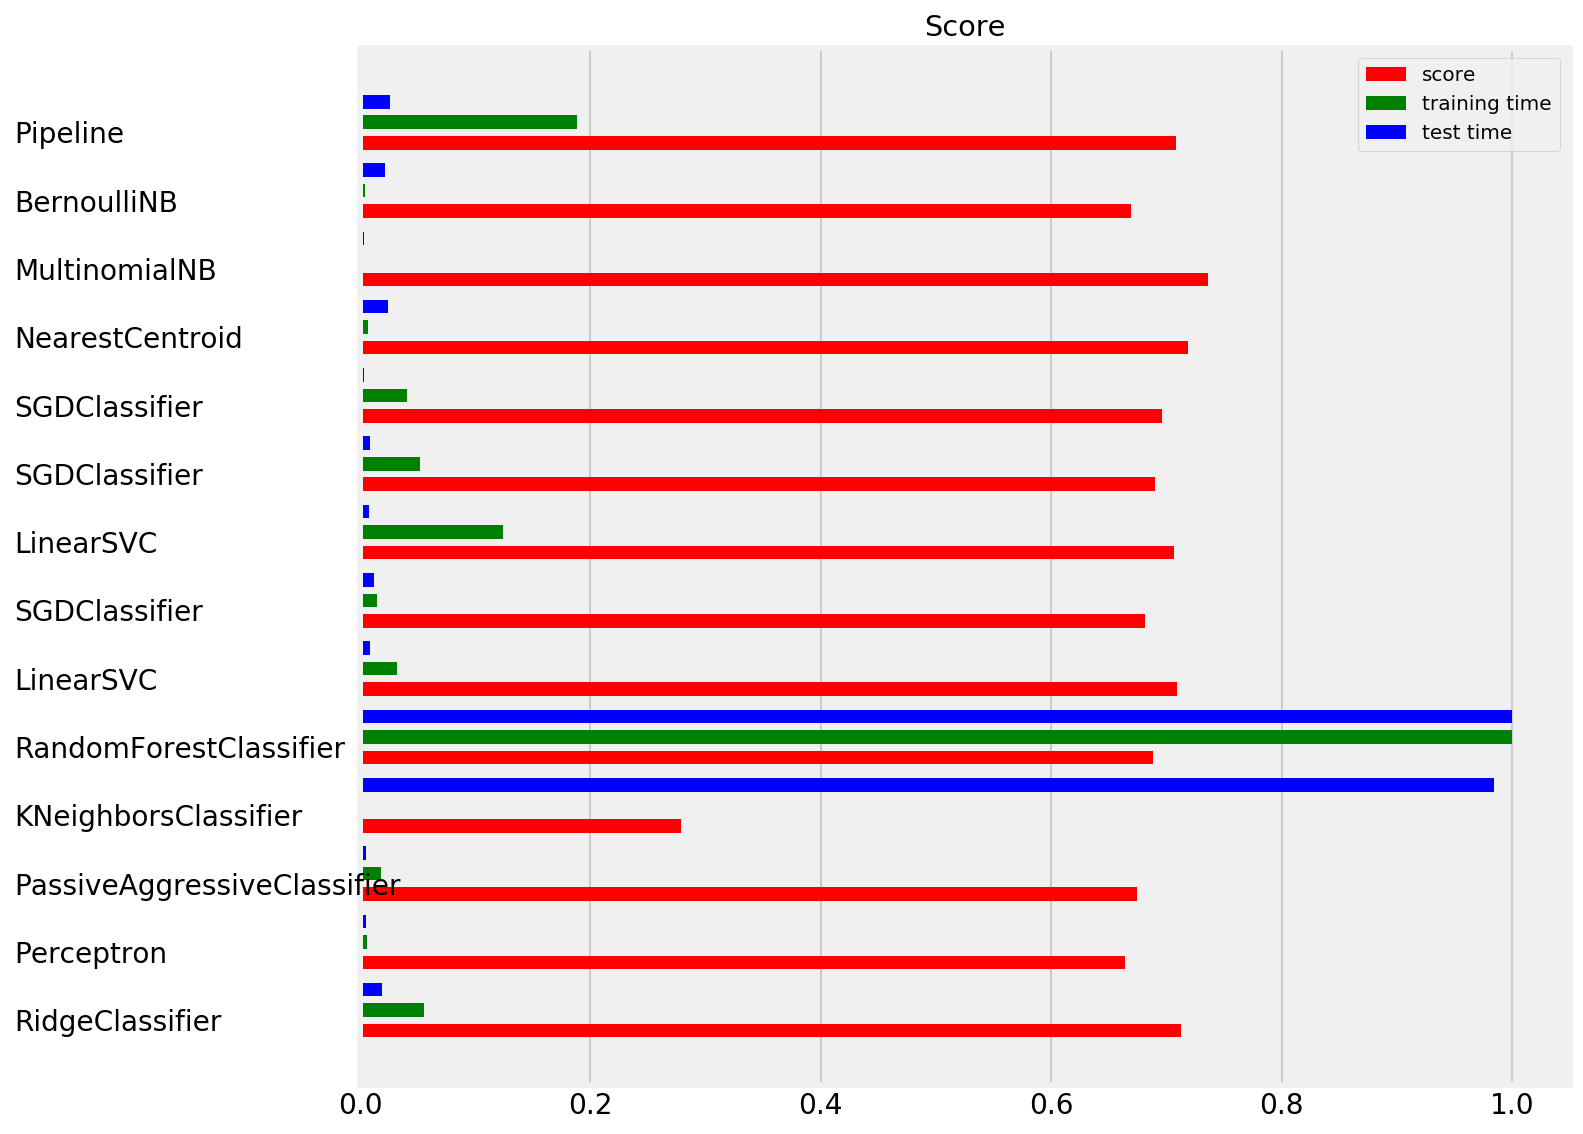

In [55]:
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

feature_names = np.array(tvec.get_feature_names())

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(data_train.target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                      % (category, " ".join(feature_names[top10])))))
        print()


    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                        target_names=data_train.target_names)))


    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=1000,tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000,tol=1e-3), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((),fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c,fontsize=14)

plt.show()

## Bonus: 

- ### Fit a model to the 20newsgroups dataset with all classes.

- ### Choose texts, for example from newspaper articles, and check what is the class label predicted for them. Does the predicted label meet your expectations?

In [56]:
#Getting all categories

data_train = fetch_20newsgroups(subset='train', 
                                categories=fetch_20newsgroups(subset='train').target_names,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', 
                               categories=fetch_20newsgroups(subset='train').target_names,#categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

In [57]:
#categories
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [58]:
# fit logistic regression
model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000),
                      LogisticRegression(),
                      )

y_train = data_train['target']
y_test = data_test['target']

model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.5322623473181094
Number of features: 1000


In [59]:
# get coefficients
model.steps[1][1].coef_.shape

(20, 1000)

In [60]:
from sklearn.linear_model import LogisticRegressionCV

In [61]:
docm(y_test, y_pred, data_train.target_names)

,p_alt.atheism,p_comp.graphics,p_comp.os.ms-windows.misc,p_comp.sys.ibm.pc.hardware,p_comp.sys.mac.hardware,p_comp.windows.x,p_misc.forsale,p_rec.autos,p_rec.motorcycles,p_rec.sport.baseball,p_rec.sport.hockey,p_sci.crypt,p_sci.electronics,p_sci.med,p_sci.space,p_soc.religion.christian,p_talk.politics.guns,p_talk.politics.mideast,p_talk.politics.misc,p_talk.religion.misc
alt.atheism,110,4,0,1,2,3,1,3,16,7,3,3,10,26,22,67,9,12,10,10
comp.graphics,6,231,26,15,10,26,5,3,15,6,0,3,19,11,12,1,0,0,0,0
comp.os.ms-windows.misc,4,24,218,38,19,22,1,2,19,5,0,2,8,13,12,2,2,0,2,1
comp.sys.ibm.pc.hardware,0,18,34,185,44,6,20,2,11,3,3,6,45,7,4,0,2,1,1,0
comp.sys.mac.hardware,3,14,9,53,196,5,15,10,22,5,2,0,31,10,8,0,1,0,0,1
comp.windows.x,0,43,34,6,9,234,7,5,18,5,0,5,17,5,4,0,1,1,1,0
misc.forsale,0,4,5,22,15,2,285,12,16,6,1,1,8,4,5,1,1,0,1,1
rec.autos,8,3,5,3,11,6,9,212,52,12,1,1,27,14,6,4,9,1,9,3
rec.motorcycles,9,3,3,7,7,3,11,36,208,20,4,3,23,17,8,5,13,3,11,4
rec.sport.baseball,8,7,1,1,0,0,7,9,35,203,74,2,13,13,7,4,1,4,8,0


In [62]:
sns.set(font_scale=1.5)

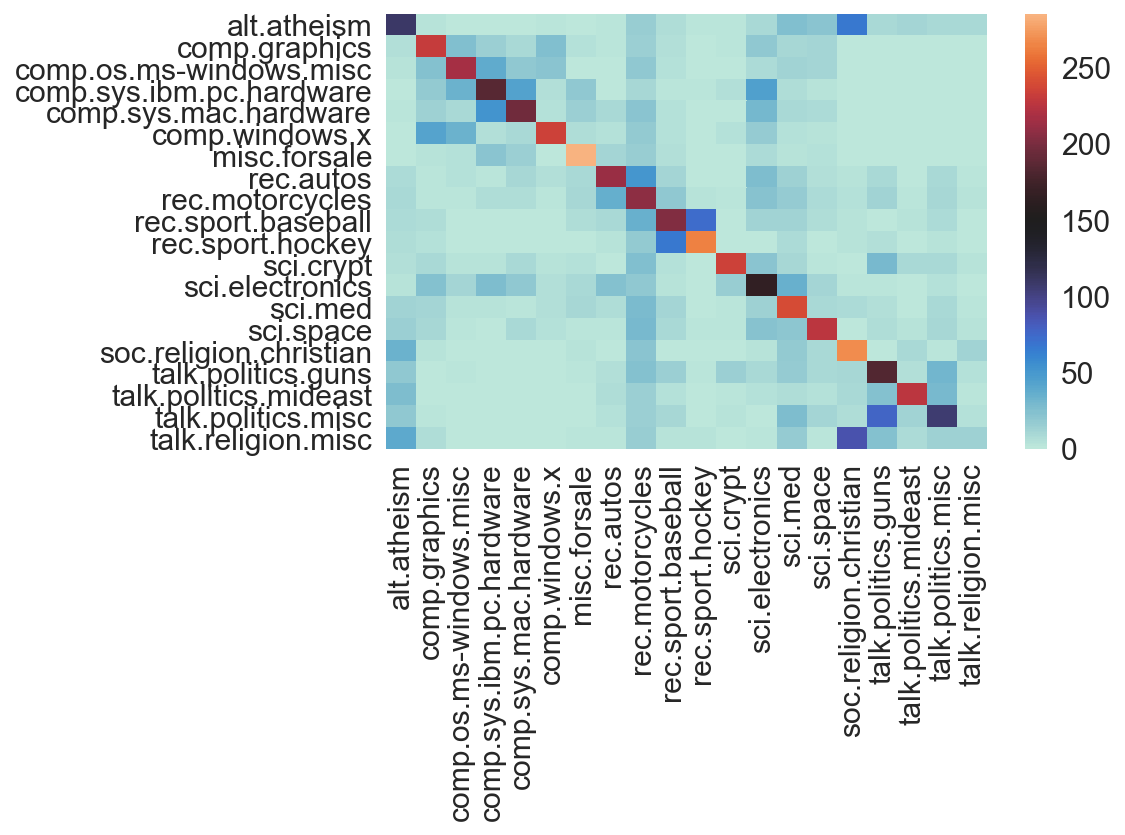

In [63]:
# heatmap for confusion matrix
sns.heatmap(docm(y_test, y_pred),xticklabels=data_train.target_names, yticklabels=data_train.target_names, center=150)
plt.show()

In [64]:
# function printing document and assigned class
def my_classifier(my_list):
    my_pred = model.predict(my_list)
    preds = [data_train.target_names[pred] for pred in my_pred]
    return list(zip(my_list,preds))

# print function
def my_printer(my):
    for i in range(len(my)):
        print('Document: ')
        print(my[i][0])
        print('Assigned class: ')
        print(my[i][1])
        print()

In [65]:
# single words
my_list = ['men','women','tree','shark','computer','internet','star',
               'quantum','magnet','english','swimming','horse','rain']
my = my_classifier(my_list)

In [66]:
my_printer(my)

Document: 
men
Assigned class: 
talk.politics.misc

Document: 
women
Assigned class: 
alt.atheism

Document: 
tree
Assigned class: 
rec.motorcycles

Document: 
shark
Assigned class: 
rec.motorcycles

Document: 
computer
Assigned class: 
comp.graphics

Document: 
internet
Assigned class: 
sci.electronics

Document: 
star
Assigned class: 
rec.motorcycles

Document: 
quantum
Assigned class: 
rec.motorcycles

Document: 
magnet
Assigned class: 
rec.motorcycles

Document: 
english
Assigned class: 
rec.motorcycles

Document: 
swimming
Assigned class: 
rec.motorcycles

Document: 
horse
Assigned class: 
rec.motorcycles

Document: 
rain
Assigned class: 
rec.motorcycles



In [67]:
# A part of a guardian article on politics 
politics = ['Ministers have dropped plans to curb the power of the House of Lords, amid concerns it could cause tensions between the government and peers before crucial Brexit legislation has to pass through parliament.']
my = my_classifier(politics)
my_printer(my)

Document: 
Ministers have dropped plans to curb the power of the House of Lords, amid concerns it could cause tensions between the government and peers before crucial Brexit legislation has to pass through parliament.
Assigned class: 
talk.politics.misc



In [68]:
# A part of a guardian article on technology
technology = ['The Tesla CEO, Elon Musk, is planning to put more than 4,000 satellites in orbit in order to blanket the Earth with internet access. SpaceX, the privateer space company led by Musk, is requesting permission from the US government to operate a massive network of 4,425 satellites - plus “in-orbit spares” - to provide high-speed, global internet coverage. Documents filed with the US Federal Communications Commission (FCC) on Tuesday propose an initial launch of 800 satellites to create an orbiting digital communications array to cover the US, including Puerto Rico and the US Virgin Islands.']
my = my_classifier(technology)
my_printer(my)

Document: 
The Tesla CEO, Elon Musk, is planning to put more than 4,000 satellites in orbit in order to blanket the Earth with internet access. SpaceX, the privateer space company led by Musk, is requesting permission from the US government to operate a massive network of 4,425 satellites - plus “in-orbit spares” - to provide high-speed, global internet coverage. Documents filed with the US Federal Communications Commission (FCC) on Tuesday propose an initial launch of 800 satellites to create an orbiting digital communications array to cover the US, including Puerto Rico and the US Virgin Islands.
Assigned class: 
sci.space



In [69]:
# The abstract of a physics paper
science = ['In the classical theory black holes can only absorb and not emit particles. However it is shown that quantum mechanical effects cause black holes to create and emit particles as if they were hot bodies with temperature where kappa is the surface gravity of the black hole. This thermal emission leads to a slow decrease in the mass of the black hole and to its eventual disappearance: any primordial black hole of mass less than about 1015 g would have evaporated by now. Although these quantum effects violate the classical law that the area of the event horizon of a black hole cannot decrease, there remains a Generalized Second Law:S+A/4 never decreases whereS is the entropy of matter outside black holes andA is the sum of the surface areas of the event horizons. This shows that gravitational collapse converts the baryons and leptons in the collapsing body into entropy. It is tempting to speculate that this might be the reason why the Universe contains so much entropy per baryon.']
my = my_classifier(science)
my_printer(my)

Document: 
In the classical theory black holes can only absorb and not emit particles. However it is shown that quantum mechanical effects cause black holes to create and emit particles as if they were hot bodies with temperature where kappa is the surface gravity of the black hole. This thermal emission leads to a slow decrease in the mass of the black hole and to its eventual disappearance: any primordial black hole of mass less than about 1015 g would have evaporated by now. Although these quantum effects violate the classical law that the area of the event horizon of a black hole cannot decrease, there remains a Generalized Second Law:S+A/4 never decreases whereS is the entropy of matter outside black holes andA is the sum of the surface areas of the event horizons. This shows that gravitational collapse converts the baryons and leptons in the collapsing body into entropy. It is tempting to speculate that this might be the reason why the Universe contains so much entropy per baryon